<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Подготовка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Подготовка данных
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#2.1-Загрузка-данных">
                            <span class="toc-item-num">2.1&nbsp;&nbsp;</span>
                            Загрузка данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#2.2-Преобразование-в-датасет">
                            <span class="toc-item-num">2.2&nbsp;&nbsp;</span>
                            Преобразование в датасет
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#3-VGG16">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    VGG16
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#4-ResNet">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    ResNet
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#6-Общий-вывод">
                    <span class="toc-item-num">6&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Классификация Oxford Pets

**Постановка задачи:** построение классификатора пород.

**Источник данных:** датасет [Oxford-IIIT](https://www.robots.ox.ac.uk/~vgg/data/pets/) | [Oxford-IIIT - Kaggle](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset).

**Характер данных:** 37 категорий домашних животных по 200 изображений на каждый класс.

**Основные этапы:**

1. Обучить три классификатора пород: на основе VGG-16/19 и на основе ResNet.
2. Посчитать точность классификатора на тестовом датасете отдельно для каждого из классификаторов, для дальнейших действий выбрать сеть с лучшей точностью.
3. Посчитать точность двоичной классификации "кошки против собак" такой сетью на тестовом датасете.
4. Построить confusion matrix.
5. *(На отличную оценку)* Посчитать top-3 и top-5 accuracy.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture --no-display
import torch
if torch.__version__ != '1.13.1+cu117':
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [4]:
%%capture --no-display
!pip install tensorflow_hub

Импорт библиотек:

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import zipfile as zf
from zipfile import ZipFile
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict

import random
import os
import glob
import itertools

import kaggle

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing import image_dataset_from_directory

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from utils.plot_charts import *

Задание случайных величин:

In [6]:
SEED = 0

np.random.seed(SEED)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current device:', device)

Current device: cuda


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Подготовка данных

### 2.1 Загрузка данных

Добавление папки `data`:

In [8]:
if os.path.isdir('data') == False:
    os.mkdir('data')

Задание пути до папки с набором данных:

In [9]:
path_data = 'data/oxford_pets'

Скачивание набора данных:

In [10]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')
    
    !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset
    
    with zf.ZipFile('the-oxfordiiit-pet-dataset.zip', 'r') as file:
        file.extractall('.')
    
    os.rename('images', 'oxford_pets')
    os.remove('the-oxfordiiit-pet-dataset.zip')
    
    os.chdir('..')

Выведение на экран изображения и его параметров:

Путь к изображению: data\oxford_pets\images\japanese_chin_197.jpg
Класс изображения: images
Высота: 375 | Ширина: 500
Размерность изображения (375, 500, 3) -> [height, width, color_channels]


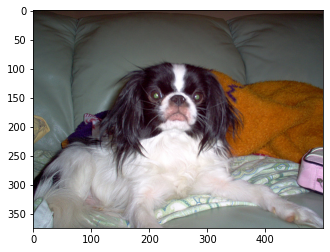

In [11]:
plot_random_image(path_data, depth='*/*')

---

### 2.2 Преобразование в датасет

In [22]:
data = pd.DataFrame(glob.glob(f'{path_data}/*'), columns=['file_path'])

In [23]:
data['file_path'] = data['file_path'].apply(lambda x: x.replace('\\', '/'))

In [24]:
data.head()

,file_path
0,data/oxford_pets/Abyssinian_1.jpg
1,data/oxford_pets/Abyssinian_10.jpg
2,data/oxford_pets/Abyssinian_100.jpg
3,data/oxford_pets/Abyssinian_100.mat
4,data/oxford_pets/Abyssinian_101.jpg


In [25]:
data['file_name'] = data['file_path'].str.split(f'{path_data}/').str[1]

In [26]:
data['label'] = data['file_name'].str.rsplit('_').str[0]

In [27]:
data.head()

,file_path,file_name,label
0,data/oxford_pets/Abyssinian_1.jpg,Abyssinian_1.jpg,Abyssinian
1,data/oxford_pets/Abyssinian_10.jpg,Abyssinian_10.jpg,Abyssinian
2,data/oxford_pets/Abyssinian_100.jpg,Abyssinian_100.jpg,Abyssinian
3,data/oxford_pets/Abyssinian_100.mat,Abyssinian_100.mat,Abyssinian
4,data/oxford_pets/Abyssinian_101.jpg,Abyssinian_101.jpg,Abyssinian


In [69]:
labels = data['label'].unique()

labels

array(['Abyssinian', 'american', 'basset', 'beagle', 'Bengal', 'Birman',
       'Bombay', 'boxer', 'British', 'chihuahua', 'Egyptian', 'english',
       'german', 'great', 'havanese', 'images', 'japanese', 'keeshond',
       'leonberger', 'Maine', 'miniature', 'newfoundland', 'Persian',
       'pomeranian', 'pug', 'Ragdoll', 'Russian', 'saint', 'samoyed',
       'scottish', 'shiba', 'Siamese', 'Sphynx', 'staffordshire',
       'wheaten', 'yorkshire'], dtype=object)

In [45]:
len(data)

7394

In [58]:
test_data = data.sample(740)
train_data = data.drop(test_data.index, axis=0) 

test_data = test_data.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [61]:
len(test_data), len(train_data)

(740, 6654)

In [ ]:
class ImageFolderCustom(Dataset):
    
    def __init__(self, 
                 target_dir: str, 
                 transform: torchvision.transforms.transforms.Compose = None,
                 depth: str = '*/*') -> None:
        
        self.paths = list(pathlib.Path(target_dir).glob(f'{depth}.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = get_classes(target_dir)
        
    def load_image(self, index: int) -> Image.Image:
        '''Open image and return it'''
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self) -> int:
        '''Return total number of samples'''
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        '''Return data and label of sample'''
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [62]:
labels = data['label'].unique()

In [38]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

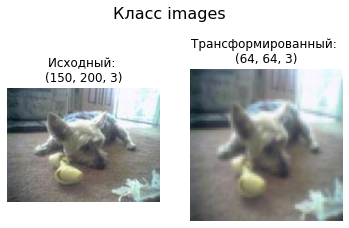

In [44]:
plot_transformed_images(data_transforms, 1, path_data, depth='*/*')

In [63]:
BATCH_SIZE = 1

In [64]:
train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)

In [65]:
train_dataloader.dataset

,file_path,file_name,label
0,data/oxford_pets/Abyssinian_10.jpg,Abyssinian_10.jpg,Abyssinian
1,data/oxford_pets/Abyssinian_100.jpg,Abyssinian_100.jpg,Abyssinian
2,data/oxford_pets/Abyssinian_100.mat,Abyssinian_100.mat,Abyssinian
3,data/oxford_pets/Abyssinian_102.jpg,Abyssinian_102.jpg,Abyssinian
4,data/oxford_pets/Abyssinian_102.mat,Abyssinian_102.mat,Abyssinian
...,...,...,...
6649,data/oxford_pets/yorkshire_terrier_95.jpg,yorkshire_terrier_95.jpg,yorkshire
6650,data/oxford_pets/yorkshire_terrier_96.jpg,yorkshire_terrier_96.jpg,yorkshire
6651,data/oxford_pets/yorkshire_terrier_97.jpg,yorkshire_terrier_97.jpg,yorkshire
6652,data/oxford_pets/yorkshire_terrier_98.jpg,yorkshire_terrier_98.jpg,yorkshire


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 VGG16

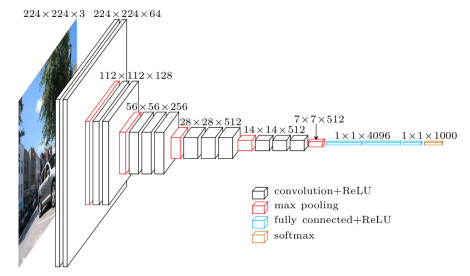

In [34]:
from torchvision import models

In [35]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

c:\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Gradt/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# change the number of classes 
vgg16.classifier[6].out_features = len(classes)
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="../Datasets/Cats&Dogs/train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="../Datasets/Cats&Dogs/validation", target_size=(224,224))

In [ ]:
# Generate the model
model = Sequential()
# Layer 1: Convolutional
model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3),
                 padding='same', activation='relu'))
# Layer 2: Convolutional
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 3: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 4: Convolutional
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 5: Convolutional
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 6: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 7: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 8: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 9: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 10: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 11: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 12: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 13: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 14: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 15: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 16: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 17: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 18: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 19: Flatten
model.add(Flatten())
# Layer 20: Fully Connected Layer
model.add(Dense(units=4096, activation='relu'))
# Layer 21: Fully Connected Layer
model.add(Dense(units=4096, activation='relu'))
# Layer 22: Softmax Layer
model.add(Dense(units=2, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Check model summary
print(model.summary())

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

In [ ]:
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
hist = model.fit_generator(steps_per_epoch=100, generator=train_generator, validation_data=valid_generator,
                           validation_steps=10, epochs=100,
                           callbacks=[checkpoint, earlystop])

In [ ]:
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show(block=True)

In [ ]:
img = image.load_img("../Datasets/Cats&Dogs/test1/39.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')

In [ ]:
#predictions = model.predict_generator(validation_generator, steps=test_steps_per_epoch)
predictions = model.predict(X_test)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = numpy.argmax(y_test, axis=1)
class_labels = list(validation_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
     
    plt.tight_layout()
    plt.ylabel('True label',color='blue')
    plt.xlabel('Predicted label',color='blue')


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_labels, title="Confusion matrix")

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 ResNet

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 5 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>